In [6]:
# importing necessary library
import os
# importing necessary library
import kagglehub
# importing necessary library
import pandas as pd
# importing necessary library
import torch
# importing necessary library
import torch.nn as nn
# importing necessary library
import torch.nn.functional as F
# importing necessary library
import math
# importing necessary library
import copy

In [5]:
from datasets import load_dataset

# Load a small portion (1%) of the scientific papers (arXiv) dataset
dataset = load_dataset("scientific_papers", "arxiv", split="train[:1%]")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.27k [00:00<?, ?B/s]

scientific_papers.py:   0%|          | 0.00/5.35k [00:00<?, ?B/s]

The repository for scientific_papers contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scientific_papers.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

In [7]:
print(dataset[0].keys())


dict_keys(['article', 'abstract', 'section_names'])


In [8]:
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

# Training tokenizer from scratch using article → abstract
with open("corpus.txt", "w", encoding="utf-8") as f:
    for sample in dataset:
        f.write(sample['article'].replace("\n", " ") + "\n")   # input
        f.write(sample['abstract'].replace("\n", " ") + "\n")  # target/summary

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(
    files="corpus.txt",
    vocab_size=30522,
    min_frequency=2,
    special_tokens=["<s>", "</s>", "<pad>", "<unk>"]
)
import os
os.makedirs("custom_tokenizer", exist_ok=True)
tokenizer.save_model("custom_tokenizer")

tokenizer = ByteLevelBPETokenizer(
    "custom_tokenizer/vocab.json",
    "custom_tokenizer/merges.txt"
)
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>"))
)
tokenizer.enable_truncation(max_length=128)


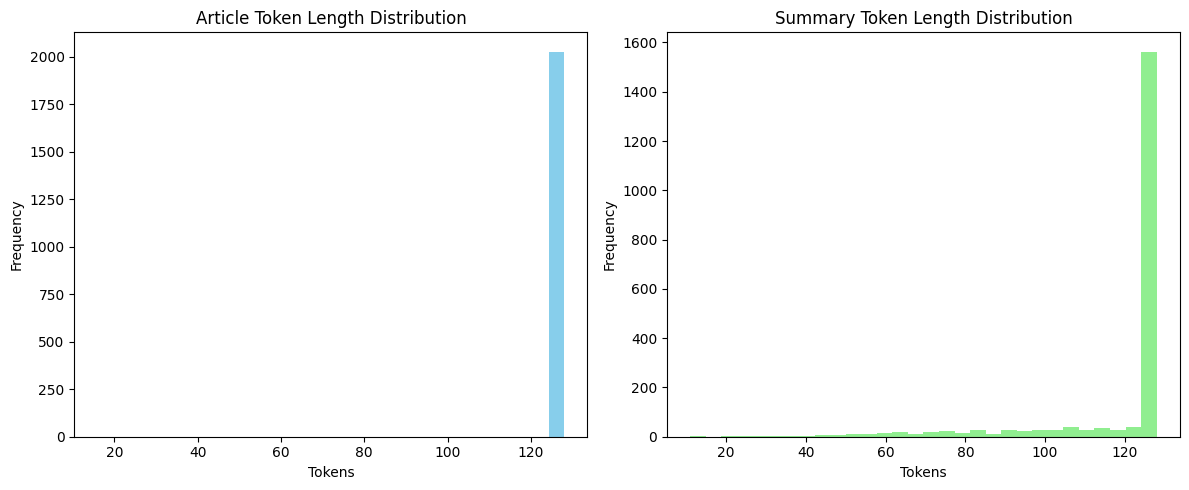

In [40]:
import matplotlib.pyplot as plt

article_lengths = [len(tokenizer.encode(sample["article"]).ids) for sample in dataset]
summary_lengths = [len(tokenizer.encode(sample["abstract"]).ids) for sample in dataset]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(article_lengths, bins=30, color="skyblue")
plt.title("Article Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(summary_lengths, bins=30, color="lightgreen")
plt.title("Summary Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [9]:
def preprocess(example):
    input_ids = tokenizer.encode(example["article"]).ids[:128]
    target_ids = tokenizer.encode(example["abstract"]).ids[:32]

    input_ids += [tokenizer.token_to_id("<pad>")] * (128 - len(input_ids))
    target_ids = [tokenizer.token_to_id("<s>")] + target_ids + [tokenizer.token_to_id("</s>")]
    target_ids += [tokenizer.token_to_id("<pad>")] * (34 - len(target_ids))

    return {"input_ids": input_ids, "labels": target_ids}


In [10]:
dataset = dataset.map(preprocess)



Map:   0%|          | 0/2030 [00:00<?, ? examples/s]

In [11]:
print(dataset[0].keys())


dict_keys(['article', 'abstract', 'section_names', 'input_ids', 'labels'])


In [12]:
# Utility: Clone layers
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [13]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Creating constant 'pe' matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Adding positional encoding
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [14]:
# Layer Normalization
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [15]:
# Sublayer Connection (Residual + Norm)
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [16]:
# Multi-Head Attention
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = torch.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [17]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]

        x, self.attn = attention(query, key, value, mask, self.dropout)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [18]:
# Position-wise Feed Forward
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [19]:
# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [20]:
# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [21]:
# Encoder and Decoder Stacks
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [22]:
# Embeddings with Positional Encoding
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [23]:
# Full model
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [24]:
# Generator
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

# Mask to block future positions
def subsequent_mask(size):
    attn_shape = (1, size, size)
    mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return mask == 0

In [25]:
# Build full model
def make_model(vocab_size, N=6, d_model=768, d_ff=3072, h=8, dropout=0.2):
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, attn, ff, dropout), N),
        Decoder(DecoderLayer(d_model, attn, attn, ff, dropout), N),
        nn.Sequential(Embeddings(d_model, vocab_size), position),
        nn.Sequential(Embeddings(d_model, vocab_size), position),
        Generator(d_model, vocab_size)
    )
    return model


In [26]:
def subsequent_mask(size):
    "Mask out subsequent positions (for auto-regressive decoding)"
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0


In [27]:
from torch.utils.data import Dataset, DataLoader

class ArxivDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        src = torch.tensor(item["input_ids"])
        tgt = torch.tensor(item["labels"])
        return src, tgt

# Create dataset and dataloader
dataset = ArxivDataset(dataset)  # ← your preprocessed HuggingFace dataset
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)


In [28]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Get vocab size and pad ID
vocab_size = tokenizer.get_vocab_size()
pad_token_id = tokenizer.token_to_id("<pad>")

# Build model
model = make_model(vocab_size).to("cuda" if torch.cuda.is_available() else "cpu")

# Loss and optimizer
loss_fn = nn.NLLLoss(ignore_index=pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    model.train()
    total_loss = 0

    for src, tgt in tqdm(train_loader):
     src = src.to(device)
     tgt = tgt.to(device)

     tgt_input = tgt[:, :-1]
     tgt_output = tgt[:, 1:]

    # Create masks
     src_mask = (src != pad_token_id).unsqueeze(-2)  # shape: [batch, 1, seq_len]
     tgt_mask = (tgt_input != pad_token_id).unsqueeze(-2)  # shape: [batch, 1, tgt_len]
     tgt_mask = tgt_mask & subsequent_mask(tgt_input.size(-1)).to(device)

    # Forward pass with masks
     out = model(src, tgt_input, src_mask, tgt_mask)
     logits = model.generator(out)

     logits = logits.view(-1, logits.size(-1))
     tgt_output = tgt_output.contiguous().view(-1)

     loss = loss_fn(logits, tgt_output)
     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

     total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Average loss: {avg_loss:.4f}")



Epoch 1/100


100%|██████████| 254/254 [00:31<00:00,  8.09it/s]


Average loss: 6.9442

Epoch 2/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 5.7312

Epoch 3/100


100%|██████████| 254/254 [00:30<00:00,  8.21it/s]


Average loss: 5.3705

Epoch 4/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 5.0915

Epoch 5/100


100%|██████████| 254/254 [00:30<00:00,  8.27it/s]


Average loss: 4.8565

Epoch 6/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 4.6498

Epoch 7/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 4.4568

Epoch 8/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 4.2828

Epoch 9/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 4.1200

Epoch 10/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 3.9630

Epoch 11/100


100%|██████████| 254/254 [00:30<00:00,  8.29it/s]


Average loss: 3.8208

Epoch 12/100


100%|██████████| 254/254 [00:30<00:00,  8.27it/s]


Average loss: 3.6830

Epoch 13/100


100%|██████████| 254/254 [00:30<00:00,  8.27it/s]


Average loss: 3.5558

Epoch 14/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 3.4357

Epoch 15/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 3.3228

Epoch 16/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 3.2170

Epoch 17/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 3.1191

Epoch 18/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 3.0192

Epoch 19/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 2.9247

Epoch 20/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 2.8321

Epoch 21/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 2.7471

Epoch 22/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 2.6607

Epoch 23/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 2.5714

Epoch 24/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 2.4926

Epoch 25/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 2.4114

Epoch 26/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 2.3269

Epoch 27/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 2.2485

Epoch 28/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 2.1631

Epoch 29/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 2.0848

Epoch 30/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 2.0029

Epoch 31/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 1.9257

Epoch 32/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 1.8473

Epoch 33/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 1.7674

Epoch 34/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 1.6872

Epoch 35/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 1.6205

Epoch 36/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 1.5411

Epoch 37/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 1.4682

Epoch 38/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 1.3898

Epoch 39/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 1.3222

Epoch 40/100


100%|██████████| 254/254 [00:30<00:00,  8.27it/s]


Average loss: 1.2543

Epoch 41/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 1.1899

Epoch 42/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 1.1230

Epoch 43/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 1.0683

Epoch 44/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 1.0095

Epoch 45/100


100%|██████████| 254/254 [00:30<00:00,  8.27it/s]


Average loss: 0.9503

Epoch 46/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.9017

Epoch 47/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 0.8482

Epoch 48/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.8020

Epoch 49/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.7592

Epoch 50/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.7128

Epoch 51/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.6734

Epoch 52/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.6351

Epoch 53/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 0.6051

Epoch 54/100


100%|██████████| 254/254 [00:30<00:00,  8.27it/s]


Average loss: 0.5767

Epoch 55/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.5431

Epoch 56/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.5121

Epoch 57/100


100%|██████████| 254/254 [00:30<00:00,  8.27it/s]


Average loss: 0.4883

Epoch 58/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.4656

Epoch 59/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.4441

Epoch 60/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.4249

Epoch 61/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.4064

Epoch 62/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.3897

Epoch 63/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.3765

Epoch 64/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.3604

Epoch 65/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.3469

Epoch 66/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.3387

Epoch 67/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.3257

Epoch 68/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.3138

Epoch 69/100


100%|██████████| 254/254 [00:30<00:00,  8.22it/s]


Average loss: 0.3054

Epoch 70/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.2949

Epoch 71/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 0.2952

Epoch 72/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.2846

Epoch 73/100


100%|██████████| 254/254 [00:30<00:00,  8.20it/s]


Average loss: 0.2717

Epoch 74/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.2685

Epoch 75/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.2584

Epoch 76/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.2528

Epoch 77/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.2475

Epoch 78/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.2443

Epoch 79/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.2373

Epoch 80/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.2354

Epoch 81/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 0.2305

Epoch 82/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 0.2217

Epoch 83/100


100%|██████████| 254/254 [00:30<00:00,  8.27it/s]


Average loss: 0.2201

Epoch 84/100


100%|██████████| 254/254 [00:30<00:00,  8.27it/s]


Average loss: 0.2181

Epoch 85/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.2112

Epoch 86/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.2098

Epoch 87/100


100%|██████████| 254/254 [00:30<00:00,  8.22it/s]


Average loss: 0.2073

Epoch 88/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.2039

Epoch 89/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.1998

Epoch 90/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.1992

Epoch 91/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 0.1935

Epoch 92/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.1910

Epoch 93/100


100%|██████████| 254/254 [00:30<00:00,  8.26it/s]


Average loss: 0.1888

Epoch 94/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.1847

Epoch 95/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.1828

Epoch 96/100


100%|██████████| 254/254 [00:30<00:00,  8.24it/s]


Average loss: 0.1785

Epoch 97/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]


Average loss: 0.1787

Epoch 98/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.1797

Epoch 99/100


100%|██████████| 254/254 [00:30<00:00,  8.23it/s]


Average loss: 0.1733

Epoch 100/100


100%|██████████| 254/254 [00:30<00:00,  8.25it/s]

Average loss: 0.1724


In [30]:
def generate_summary(model, input_text, tokenizer, max_len=64):
    model.eval()

    # Tokenize the input text (article)
    input_ids = tokenizer.encode(input_text).ids[:128]
    input_ids += [tokenizer.token_to_id("<pad>")] * (128 - len(input_ids))
    src = torch.tensor([input_ids]).to(next(model.parameters()).device)
    src_mask = (src != tokenizer.token_to_id("<pad>")).unsqueeze(-2)

    # Special token IDs
    start_symbol = tokenizer.token_to_id("<s>")
    eos_symbol = tokenizer.token_to_id("</s>")

    # Decode
    decoded_ids = greedy_decode(model, src, src_mask, max_len, start_symbol, eos_symbol)

    # Remove padding and decode to string
    token_ids = [t for t in decoded_ids[0].tolist() if t not in [
    tokenizer.token_to_id("<pad>"),
    tokenizer.token_to_id("<s>"),
    tokenizer.token_to_id("</s>")]]

    return tokenizer.decode(token_ids)

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bertscore
from nltk.tokenize import word_tokenize

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup
vocab_size = tokenizer.get_vocab_size()
pad_token_id = tokenizer.token_to_id("<pad>")
model = make_model(vocab_size).to(device)

# Loss and optimizer
loss_fn = nn.NLLLoss(ignore_index=pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Metric tracking
epochs = 20
loss_history = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
bleu_scores = []
bertscore_f1s = []

# Metric helpers
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
smoothie = SmoothingFunction().method4

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{epochs}")

    for src, tgt in tqdm(train_loader):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        src_mask = (src != pad_token_id).unsqueeze(-2)
        tgt_mask = (tgt_input != pad_token_id).unsqueeze(-2) & subsequent_mask(tgt_input.size(-1)).to(device)

        out = model(src, tgt_input, src_mask, tgt_mask)
        logits = model.generator(out)

        logits = logits.view(-1, logits.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)

        loss = loss_fn(logits, tgt_output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Loss
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"🔹 Avg Loss: {avg_loss:.4f}")

    # Evaluate on 1 sample
    model.eval()
    sample = dataset[0]["article"]
    reference = dataset[0]["abstract"]
    prediction = generate_summary(model, sample, tokenizer)

    # ROUGE
    scores = scorer.score(reference, prediction)
    rouge1_scores.append(scores["rouge1"].fmeasure)
    rouge2_scores.append(scores["rouge2"].fmeasure)
    rougeL_scores.append(scores["rougeL"].fmeasure)

    # BLEU
    ref_tokens = word_tokenize(reference)
    pred_tokens = word_tokenize(prediction)
    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    bleu_scores.append(bleu)

    # BERTScore
    _, _, f1 = bertscore([prediction], [reference], lang="en", verbose=False)
    bertscore_f1s.append(f1[0].item())

    # Print metrics
    print(f"ROUGE-1: {scores['rouge1'].fmeasure:.4f} | ROUGE-2: {scores['rouge2'].fmeasure:.4f} | ROUGE-L: {scores['rougeL'].fmeasure:.4f}")
    print(f" BLEU: {bleu:.4f} |  BERTScore F1: {f1[0].item():.4f}")





Epoch 1/20


100%|██████████| 254/254 [00:32<00:00,  7.92it/s]


🔹 Avg Loss: 6.9543


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7823

Epoch 2/20


100%|██████████| 254/254 [00:32<00:00,  7.93it/s]


🔹 Avg Loss: 5.7278


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0765 | ROUGE-2: 0.0000 | ROUGE-L: 0.0546
 BLEU: 0.0019 |  BERTScore F1: 0.7646

Epoch 3/20


100%|██████████| 254/254 [00:32<00:00,  7.93it/s]


🔹 Avg Loss: 5.3690


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7730

Epoch 4/20


100%|██████████| 254/254 [00:31<00:00,  7.98it/s]


🔹 Avg Loss: 5.0906


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0541 | ROUGE-2: 0.0000 | ROUGE-L: 0.0541
 BLEU: 0.0001 |  BERTScore F1: 0.7774

Epoch 5/20


100%|██████████| 254/254 [00:31<00:00,  7.96it/s]


🔹 Avg Loss: 4.8587


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0839 | ROUGE-2: 0.0142 | ROUGE-L: 0.0420
 BLEU: 0.0000 |  BERTScore F1: 0.7877

Epoch 6/20


100%|██████████| 254/254 [00:31<00:00,  7.98it/s]


🔹 Avg Loss: 4.6447


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0680 | ROUGE-2: 0.0000 | ROUGE-L: 0.0544
 BLEU: 0.0000 |  BERTScore F1: 0.7667

Epoch 7/20


100%|██████████| 254/254 [00:31<00:00,  8.00it/s]


🔹 Avg Loss: 4.4526


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0595 | ROUGE-2: 0.0000 | ROUGE-L: 0.0238
 BLEU: 0.0009 |  BERTScore F1: 0.7729

Epoch 8/20


100%|██████████| 254/254 [00:31<00:00,  7.97it/s]


🔹 Avg Loss: 4.2744


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0278 | ROUGE-2: 0.0000 | ROUGE-L: 0.0278
 BLEU: 0.0000 |  BERTScore F1: 0.7819

Epoch 9/20


100%|██████████| 254/254 [00:31<00:00,  7.97it/s]


🔹 Avg Loss: 4.1121


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0556 | ROUGE-2: 0.0000 | ROUGE-L: 0.0556
 BLEU: 0.0015 |  BERTScore F1: 0.7796

Epoch 10/20


100%|██████████| 254/254 [00:31<00:00,  8.00it/s]


🔹 Avg Loss: 3.9523


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0145 | ROUGE-2: 0.0000 | ROUGE-L: 0.0145
 BLEU: 0.0000 |  BERTScore F1: 0.7674

Epoch 11/20


100%|██████████| 254/254 [00:31<00:00,  7.98it/s]


🔹 Avg Loss: 3.8021


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0146 | ROUGE-2: 0.0000 | ROUGE-L: 0.0146
 BLEU: 0.0000 |  BERTScore F1: 0.7720

Epoch 12/20


100%|██████████| 254/254 [00:31<00:00,  7.99it/s]


🔹 Avg Loss: 3.6665


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0447 | ROUGE-2: 0.0000 | ROUGE-L: 0.0335
 BLEU: 0.0014 |  BERTScore F1: 0.7692

Epoch 13/20


100%|██████████| 254/254 [00:31<00:00,  7.97it/s]


🔹 Avg Loss: 3.5362


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7643

Epoch 14/20


100%|██████████| 254/254 [00:31<00:00,  7.98it/s]


🔹 Avg Loss: 3.4144


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0451 | ROUGE-2: 0.0000 | ROUGE-L: 0.0451
 BLEU: 0.0000 |  BERTScore F1: 0.7874

Epoch 15/20


100%|██████████| 254/254 [00:31<00:00,  7.99it/s]


🔹 Avg Loss: 3.2989


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0435 | ROUGE-2: 0.0000 | ROUGE-L: 0.0326
 BLEU: 0.0017 |  BERTScore F1: 0.7828

Epoch 16/20


100%|██████████| 254/254 [00:31<00:00,  8.00it/s]


🔹 Avg Loss: 3.1873


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7757

Epoch 17/20


100%|██████████| 254/254 [00:31<00:00,  7.98it/s]


🔹 Avg Loss: 3.0827


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0984 | ROUGE-2: 0.0110 | ROUGE-L: 0.0656
 BLEU: 0.0037 |  BERTScore F1: 0.7951

Epoch 18/20


100%|██████████| 254/254 [00:31<00:00,  7.99it/s]


🔹 Avg Loss: 2.9776


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0649 | ROUGE-2: 0.0132 | ROUGE-L: 0.0390
 BLEU: 0.0004 |  BERTScore F1: 0.7983

Epoch 19/20


100%|██████████| 254/254 [00:31<00:00,  7.98it/s]


🔹 Avg Loss: 2.8852


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0914 | ROUGE-2: 0.0116 | ROUGE-L: 0.0571
 BLEU: 0.0015 |  BERTScore F1: 0.7871

Epoch 20/20


100%|██████████| 254/254 [00:31<00:00,  7.97it/s]


🔹 Avg Loss: 2.7842


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7656


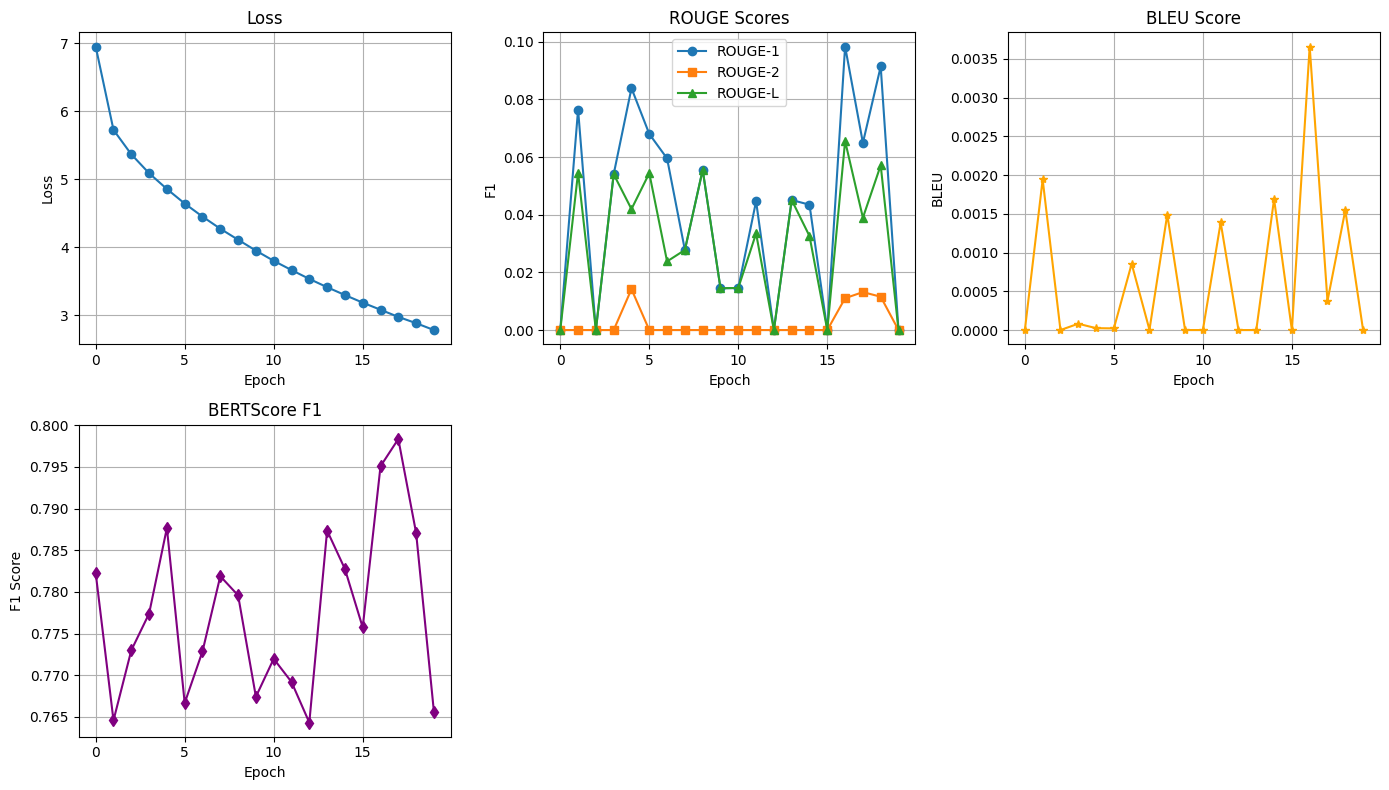

In [52]:
plt.figure(figsize=(14, 8))

# Loss
plt.subplot(2, 3, 1)
plt.plot(loss_history, marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# ROUGE-1
plt.subplot(2, 3, 2)
plt.plot(rouge1_scores, label="ROUGE-1", marker='o')
plt.plot(rouge2_scores, label="ROUGE-2", marker='s')
plt.plot(rougeL_scores, label="ROUGE-L", marker='^')
plt.title("ROUGE Scores")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.grid(True)

# BLEU
plt.subplot(2, 3, 3)
plt.plot(bleu_scores, marker='*', color='orange')
plt.title("BLEU Score")
plt.xlabel("Epoch")
plt.ylabel("BLEU")
plt.grid(True)

# BERTScore
plt.subplot(2, 3, 4)
plt.plot(bertscore_f1s, marker='d', color='purple')
plt.title("BERTScore F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()


In [29]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, eos_symbol):
    model.eval()
    memory = model.encode(src, src_mask)

    # Start with <s> token
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src).to(src.device)

    for _ in range(max_len - 1):
        tgt_mask = subsequent_mask(ys.size(1)).to(src.device).unsqueeze(1)
        out = model.decode(memory, src_mask, ys, tgt_mask)

        # Use sampling instead of argmax
        probs = torch.softmax(model.generator(out[:, -1]), dim=-1)
        next_word = torch.multinomial(probs, num_samples=1)

        ys = torch.cat([ys, next_word], dim=1)

        # Stop decoding if </s> token is generated
        if next_word.item() == eos_symbol:
            break

    return ys


In [31]:
from datasets import load_dataset
raw_dataset = load_dataset("scientific_papers", "arxiv", split="train[:1%]")


In [38]:
import re

def clean_and_filter(example):
    # Replace all @xmath0, @xmath1, etc. with [MATH]
    article = re.sub(r"@xmath\d+", "[MATH]", example["article"])
    abstract = re.sub(r"@xmath\d+", "[MATH]", example["abstract"])

    # Filter by article length (in characters)
    if 50 <= len(article) <= 1000:
        return {
            "article": article,
            "abstract": abstract,
            "section_names": example.get("section_names", "")
        }
    else:
        return None  # Drop this example


In [32]:
sample_abstract = raw_dataset[1]["article"]
generated_title = generate_summary(model, sample_abstract, tokenizer)
print("Generated Title:", generated_title)


Generated Title:  we have studied the leptonic decay @xmath1 , using a sample corresponding typical cp violations @xmath0 , using a sample corresponding unpolarized high-@xmath1 , using a sample open quantum critical center @xmath2 decays collected near the @xmath0 , using a sample corresponding typical equation @xmath2 decays collected near


In [33]:
from datasets import load_dataset
raw_dataset = load_dataset("scientific_papers", "arxiv", split="train[:1%]")

for i in range(5):
    print(f"\nSample {i+1}")
    article = raw_dataset[i]["article"]
    target = raw_dataset[i]["abstract"]
    predicted = generate_summary(model, article, tokenizer)

    print(" Reference:", target[:200], "...")
    print(" Generated:", predicted)
    print("-" * 80)



Sample 1
 Reference:  additive models play an important role in semiparametric statistics . 
 this paper gives learning rates for regularized kernel based methods for additive models . 
 these learning rates compare favou ...
 Generated:  additive models . 
 this paper gives learning rates compare fav
--------------------------------------------------------------------------------

Sample 2
 Reference:  we have studied the leptonic decay @xmath0 , via the decay channel @xmath1 , using a sample of tagged @xmath2 decays collected near the @xmath3 peak production energy in @xmath4 collisions with the c ...
 Generated:  we have studied the leptonic decay channel @xmath2 decays collected near the @xmath1 , using a sample of production space dimensional @
--------------------------------------------------------------------------------

Sample 3
 Reference:  in 84 , 258 ( 2000 ) , mateos conjectured that current reversal in a classical deterministic ratchet is associated with bifurcations fr

In [36]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)

def evaluate_model(model, tokenizer, dataset, n=5):
    for i in range(n):
        article = dataset[i]["article"]
        reference = dataset[i]["abstract"]
        generated = generate_summary(model, article, tokenizer)

        scores = scorer.score(reference, generated)

        print(f"\nSample {i+1}")
        print(f" Reference: {reference[:150]}...")
        print(f" Generated: {generated}")
        print(f" ROUGE-1: {scores['rouge1'].fmeasure:.4f} | ROUGE-L: {scores['rougeL'].fmeasure:.4f}")
        print("-" * 80)


In [37]:
evaluate_model(model, tokenizer, raw_dataset, n=5)



Sample 1
 Reference:  additive models play an important role in semiparametric statistics . 
 this paper gives learning rates for regularized kernel based methods for addi...
 Generated:  dyadic 2000 . 
 this paper gives learning techniques applied to examine generalizations . 
 this paper gives learning capabilities provided plentiful evidence for additive models . 
 these learning nature remains open these learning capabilities provided plentiful evidence for additive models . 
 this paper gives learning capabilities provided plentiful using semiclassical trace formula as agan to examine generalizations
 ROUGE-1: 0.2099 | ROUGE-L: 0.1657
--------------------------------------------------------------------------------

Sample 2
 Reference:  we have studied the leptonic decay @xmath0 , via the decay channel @xmath1 , using a sample of tagged @xmath2 decays collected near the @xmath3 peak ...
 Generated:  the decay channel @xmath0 , using a and @xmath0 , using a sample corresponding to